# first setup for EDA
This notebooks gives a first setup for the EDA for the NHS data.
The wonderfull work by Laurence resented in the following [notebook](https://github.com/laurencefrank/NHS-PROMs/blob/main/notebooks/nb1_NHS_PROMs_G5.ipynb)

## imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import warnings
import re

from sklearn.preprocessing import OrdinalEncoder

from utils.load_data import dir_digger, read_csv_zip, structure_name, get_meta, clean_data
from utils.data_dictionary import methods, column_meta


In [2]:
EXT_DATA = "..\data\external"
INT_DATA = "..\data\interim"
N_PLOT_SAMPLES = 10_000

## parse files

### load + clean interim

In [3]:
files = dir_digger(INT_DATA, ext=".parquet")
print(f"Found {len(files)} files:")
display(files)

df_hip_raw = (
    pd.concat([pd.read_parquet(file) for file in files if "hip" in file])
    .drop_duplicates()
    .rename(structure_name, axis=1)
)
df_knee_raw = (
    pd.concat([pd.read_parquet(file) for file in files if "knee" in file])
    .drop_duplicates()
    .rename(structure_name, axis=1)
)

Found 4 files:


['..\\data\\interim\\hip-ccg.parquet',
 '..\\data\\interim\\hip-provider.parquet',
 '..\\data\\interim\\knee-ccg.parquet',
 '..\\data\\interim\\knee-provider.parquet']

In [4]:
df_raw = df_knee_raw

df_meta = get_meta(df_raw.columns)  
df_clean = clean_data(df_raw, df_meta)

if (df_clean.describe(include="all").loc["max"]==9).any():
    to_check = list(df_clean.loc[:, df_clean.describe(include="all").loc["max"]==9].columns)
    warning.warn("Please check the folowing columns for meta data:")
    display(to_check)

## general descriptives

In [5]:
df_clean.head(5)

,t0_provider_code,t0_procedure,t0_revision_flag,t0_year,t0_age_band,t0_gender,t0_assisted,t0_assisted_by,t0_symptom_period,t0_previous_surgery,...,t1_oks_walking,t1_oks_standing,t1_oks_limping,t1_oks_kneeling,t1_oks_work,t1_oks_confidence,t1_oks_shopping,t1_oks_stairs,t1_oks_score,t1_oks_predicted
0,00C,Knee Replacement,0.0,2018/19,NaN,NaN,1.0,NaN,2.0,2.0,...,4.0,3.0,4.0,4.0,4.0,4.0,4.0,2.0,43.0,35.133457
1,00C,Knee Replacement,0.0,2018/19,NaN,NaN,1.0,NaN,2.0,2.0,...,3.0,2.0,3.0,1.0,2.0,3.0,2.0,3.0,29.0,26.031412
2,00C,Knee Replacement,0.0,2018/19,NaN,NaN,2.0,NaN,4.0,2.0,...,2.0,2.0,1.0,0.0,2.0,2.0,0.0,2.0,16.0,26.818594
3,00C,Knee Replacement,0.0,2018/19,NaN,NaN,2.0,NaN,2.0,2.0,...,4.0,3.0,1.0,1.0,3.0,4.0,3.0,3.0,37.0,33.841702
4,00C,Knee Replacement,0.0,2018/19,NaN,NaN,2.0,NaN,1.0,1.0,...,4.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0,47.0,38.841248


In [6]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 275626 entries, 0 to 139235
Data columns (total 81 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   t0_provider_code        275626 non-null  object  
 1   t0_procedure            275626 non-null  category
 2   t0_revision_flag        275626 non-null  float64 
 3   t0_year                 275626 non-null  category
 4   t0_age_band             259933 non-null  object  
 5   t0_gender               259933 non-null  float32 
 6   t0_assisted             272629 non-null  float64 
 7   t0_assisted_by          0 non-null       float64 
 8   t0_symptom_period       273250 non-null  float64 
 9   t0_previous_surgery     273581 non-null  float64 
 10  t0_living_arrangements  271512 non-null  float64 
 11  t0_disability           263958 non-null  float64 
 12  t0_heart_disease        25877 non-null   float64 
 13  t0_high_bp              121961 non-null  float64 
 14  t0_s

In [7]:
df_clean.describe(include="all")

,t0_provider_code,t0_procedure,t0_revision_flag,t0_year,t0_age_band,t0_gender,t0_assisted,t0_assisted_by,t0_symptom_period,t0_previous_surgery,...,t1_oks_walking,t1_oks_standing,t1_oks_limping,t1_oks_kneeling,t1_oks_work,t1_oks_confidence,t1_oks_shopping,t1_oks_stairs,t1_oks_score,t1_oks_predicted
count,275626,275626,275626.000000,275626,259933,259933.000000,272629.000000,0.0,273250.000000,273581.000000,...,273123.000000,273633.00000,273449.000000,273462.000000,273619.000000,273749.000000,273631.000000,273683.000000,270509.000000,265962.000000
unique,492,1,NaN,3,6,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,RL1,Knee Replacement,NaN,2016/17,70 to 79,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,3135,275626,NaN,94145,109561,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,0.037533,NaN,NaN,1.570258,1.845306,NaN,2.598551,1.922250,...,3.339506,3.08154,3.074394,1.595589,3.049255,3.492188,3.163900,3.019493,35.889481,34.424835
std,NaN,NaN,0.190064,NaN,NaN,0.495040,0.361613,NaN,0.871464,0.267779,...,1.002723,0.89724,1.100624,1.337638,0.996447,0.840517,1.195671,1.032303,9.472650,4.738459
min,NaN,NaN,0.000000,NaN,NaN,1.000000,1.000000,NaN,1.000000,1.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.063292
25%,NaN,NaN,0.000000,NaN,NaN,1.000000,2.000000,NaN,2.000000,2.000000,...,3.000000,3.00000,3.000000,0.000000,2.000000,3.000000,3.000000,2.000000,30.000000,31.552515
50%,NaN,NaN,0.000000,NaN,NaN,2.000000,2.000000,NaN,2.000000,2.000000,...,4.000000,3.00000,3.000000,2.000000,3.000000,4.000000,4.000000,3.000000,38.000000,35.066414
75%,NaN,NaN,0.000000,NaN,NaN,2.000000,2.000000,NaN,3.000000,2.000000,...,4.000000,4.00000,4.000000,3.000000,4.000000,4.000000,4.000000,4.000000,43.000000,38.000938


In [8]:
df_clean.head(5)

,t0_provider_code,t0_procedure,t0_revision_flag,t0_year,t0_age_band,t0_gender,t0_assisted,t0_assisted_by,t0_symptom_period,t0_previous_surgery,...,t1_oks_walking,t1_oks_standing,t1_oks_limping,t1_oks_kneeling,t1_oks_work,t1_oks_confidence,t1_oks_shopping,t1_oks_stairs,t1_oks_score,t1_oks_predicted
0,00C,Knee Replacement,0.0,2018/19,NaN,NaN,1.0,NaN,2.0,2.0,...,4.0,3.0,4.0,4.0,4.0,4.0,4.0,2.0,43.0,35.133457
1,00C,Knee Replacement,0.0,2018/19,NaN,NaN,1.0,NaN,2.0,2.0,...,3.0,2.0,3.0,1.0,2.0,3.0,2.0,3.0,29.0,26.031412
2,00C,Knee Replacement,0.0,2018/19,NaN,NaN,2.0,NaN,4.0,2.0,...,2.0,2.0,1.0,0.0,2.0,2.0,0.0,2.0,16.0,26.818594
3,00C,Knee Replacement,0.0,2018/19,NaN,NaN,2.0,NaN,2.0,2.0,...,4.0,3.0,1.0,1.0,3.0,4.0,3.0,3.0,37.0,33.841702
4,00C,Knee Replacement,0.0,2018/19,NaN,NaN,2.0,NaN,1.0,1.0,...,4.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0,47.0,38.841248


## first plots

In [9]:
# make easy ling format of data

method_cols = df_meta["method"].notna() & (
    df_meta["feature"].isin(["predicted", "profile"]) == False
)
method_cols = method_cols[method_cols].index

new_index = [
    re.search(
        fr"^(?P<t>t[01])_?(?P<method>{'|'.join(methods)})?_(?P<feature>.*)$", col
    ).groups()
    for col in method_cols
]

df_methods = df_clean[method_cols]
names = ["available", "method", "feature"]
df_methods.columns = pd.MultiIndex.from_tuples(new_index, names=names)

df_long = df_methods.stack(names).reset_index(names).rename(columns={0: "response"})
df_long.sample(5)

,available,method,feature,response
18985,t1,eqvas,score,70.0
131718,t0,oks,score,24.0
113028,t1,oks,kneeling,0.0
9214,t1,oks,transport,3.0
66441,t1,oks,washing,4.0


### Data from methods

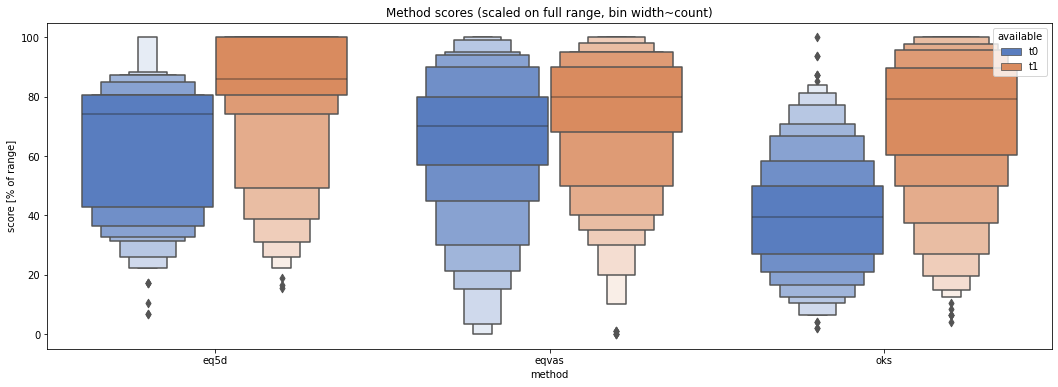

In [10]:
# plot different scores
data = df_long.query(f"method == method & feature in 'score'").sample(N_PLOT_SAMPLES).copy()
methods_order = np.sort(data["method"].unique())
# min-max scale the old way
for method in methods_order:
    min_, max_ = methods[method]["score"]["range"]
    data.loc[data["method"] == method, "response"] = (
        data.loc[data["method"] == method, "response"] - min_
    ) / (max_ - min_) * 100

# plot boxen per method score
fig, ax = plt.subplots(figsize=(18, 6))
ax = sns.boxenplot(
    x="method",
    y="response",
    order=methods_order,
    hue="available",
    hue_order=["t0", "t1"],
    data=data,
    palette="muted",
    scale="linear",
)

ax.set_title("Method scores (scaled on full range, bin width~count)")
ax.set_ylabel("score [% of range]")
plt.show()

In [1]:
labels

NameError: name 'labels' is not defined

In [2]:
for method in [
    k for k, v in methods.items() if v.get("dims") and (k in df_long["method"].unique())
]:
    # query subset for method
    data = df_long.query(f"method == '{method}' & feature not in 'score'").sample(
        N_PLOT_SAMPLES
    )

    # plot violin per method dimension
    fig, ax = plt.subplots(figsize=(18, 6))
    ax = sns.violinplot(
        x="feature",
        y="response",
        hue="available",
        hue_order=["t0", "t1"],
        data=data,
        inner=None,
        cut=0,
        palette="muted",
        split=True,
    )

    ax.set_title(f"KDE of {method.upper()} features (dimensions)")
    labels = methods[method]["dims"]["labels"].copy()
    labels.pop(9)
    ax.set_yticks(list(labels))
    ax.set_yticklabels(labels.values())
    plt.show()

NameError: name 'methods' is not defined

### Other data available

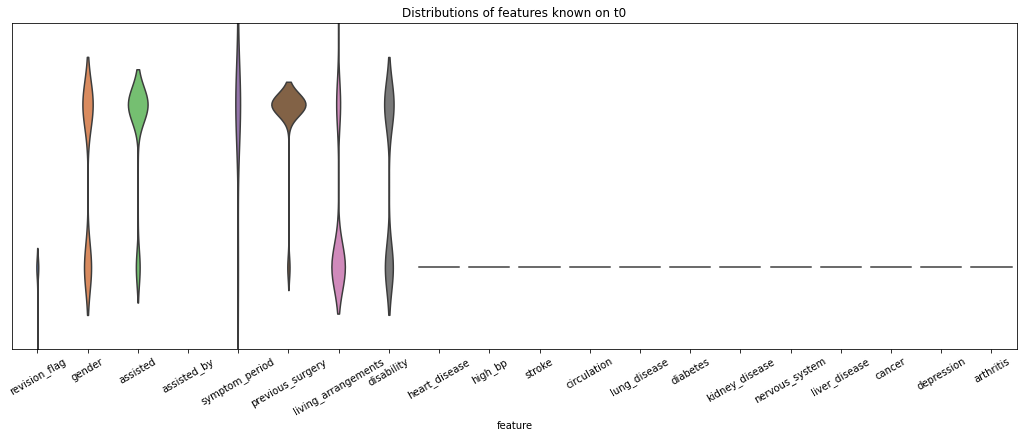

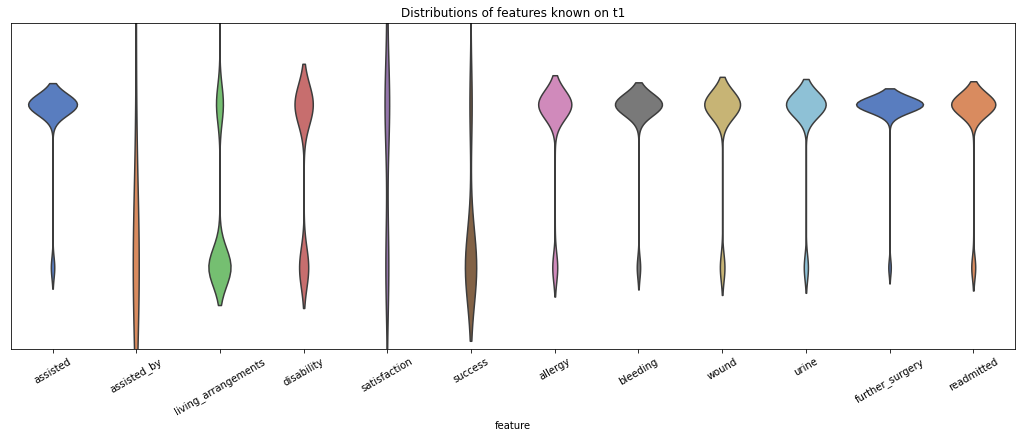

In [12]:
for available in ["t0", "t1"]:
    cols = df_meta.query(fr"method != method & t=='{available[1]}'").index
    data = df_clean.loc[:, cols]
    data.columns = pd.Index(data.columns.str.replace(r"^t[01]_", ""), name="feature")
    if available == "t0":
        data = data.drop(columns=["provider_code", "procedure", "year", "age_band"])
    
    # plot per feature
    fig, ax = plt.subplots(figsize=(18, 6))
    ax = sns.violinplot(
        x="feature",
        y="value",
        order=data.columns,
        inner=None,
        data=data.melt().sample(N_PLOT_SAMPLES),
        palette="muted",
    )

    ax.set_title(f"Distributions of features known on {available}")
    ax.set_ylim((.5, 2.5))
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
    ax.yaxis.set_visible(False)
    plt.show()

## PCA on methods

In [34]:
df_oks = df_meta.query("method == 'oks' & feature not in ('score', 'predicted')")
df_oks = df_oks.query("t == '0'").index

In [37]:
df_meta

,t,method,feature,kind,labels,range
t0_provider_code,0,NaN,provider_code,categorical,NaN,NaN
t0_procedure,0,NaN,procedure,categorical,"[{'Hip Replacement': 'hip Replacement', 'Knee ...",NaN
t0_revision_flag,0,NaN,revision_flag,categorical,"[{0: 'no revision', 1: 'revision procedure'}]",NaN
t0_year,0,NaN,year,ordinal,"[{'2016/17': 'April 2016 - April 2017', '2017/...",NaN
t0_age_band,0,NaN,age_band,ordinal,"[{'80 to 89': '80 to 89', '60 to 69': '60 to 6...",NaN
...,...,...,...,...,...,...
t1_oks_confidence,1,oks,confidence,ordinal,"[{0: 'all of the time', 1: 'most of the time',...",NaN
t1_oks_shopping,1,oks,shopping,ordinal,"[{0: 'all of the time', 1: 'most of the time',...",NaN
t1_oks_stairs,1,oks,stairs,ordinal,"[{0: 'all of the time', 1: 'most of the time',...",NaN
t1_oks_score,1,oks,score,numerical,NaN,"(0, 48)"


In [38]:
!dir

 Volume in drive C is OSDisk
 Volume Serial Number is 5E76-8D77

 Directory of C:\_NoBackup\Projects\JADS\Execute\NHS-PROMs\notebooks

02-02-2021  20:32    <DIR>          .
02-02-2021  20:32    <DIR>          ..
30-01-2021  19:03    <DIR>          .ipynb_checkpoints
29-01-2021  12:50               480 conda_env.yml
02-02-2021  20:32           378.524 EDA_BV.ipynb
28-01-2021  21:03    <DIR>          img
30-01-2021  19:04             5.548 Load_new_data_BV.ipynb
30-01-2021  19:05             2.383 Load_online_PROMs_data_BV.ipynb
29-01-2021  09:18           665.963 nb1_NHS_PROMs_G5.ipynb
30-01-2021  18:56    <DIR>          utils
               5 File(s)      1.052.898 bytes
               5 Dir(s)  24.948.920.320 bytes free


In [42]:
pd.read_parquet("../data/new_parquets/knee-ccg.parquet")

,provider_code,procedure,revision_flag,year,age_band,gender,t0_assisted,t0_assisted_by,t0_symptom_period,t0_previous_surgery,...,oks_t1_walking,oks_t1_standing,oks_t1_limping,oks_t1_kneeling,oks_t1_work,oks_t1_confidence,oks_t1_shopping,oks_t1_stairs,oks_t1_score,oks_oks_t1_predicted
0,00C,Knee Replacement,0,2016/17,NaN,NaN,2,0,2,2,...,4,3,4,0,4,3,4,3,39.0,38.310318
1,00C,Knee Replacement,0,2016/17,NaN,NaN,1,0,4,2,...,3,4,2,1,2,2,3,3,31.0,38.238083
2,00C,Knee Replacement,0,2016/17,NaN,NaN,2,0,3,2,...,4,3,3,1,4,4,4,4,41.0,27.735670
3,00C,Knee Replacement,0,2016/17,NaN,NaN,2,0,2,2,...,4,3,4,2,4,4,4,4,42.0,28.744923
4,00C,Knee Replacement,0,2016/17,NaN,NaN,2,0,2,2,...,4,3,3,0,3,4,4,4,38.0,30.004255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24264,99N,Knee Replacement,0,2019/20,80 to 89,2.0,2,0,2,2,...,2,1,3,0,1,0,2,2,15.0,40.795609
24265,99N,Knee Replacement,0,2019/20,80 to 89,2.0,2,0,2,2,...,4,4,4,3,3,3,4,3,42.0,41.504505
24266,99N,Knee Replacement,0,2019/20,80 to 89,2.0,2,0,2,2,...,4,4,4,3,4,4,4,4,47.0,39.294518
24267,99N,Knee Replacement,0,2019/20,80 to 89,2.0,2,0,2,2,...,2,2,3,0,1,3,0,1,20.0,40.679749


In [44]:
df = pd.read_parquet("../data/new_parquets/knee-provider.parquet")

In [49]:
# [structure_name(col) for col in df.columns]
df.columns.str.structure_name()

AttributeError: 'StringMethods' object has no attribute 'structure_name'